In [2]:
from __future__ import absolute_import

%matplotlib inline 
import numpy as np
import pylab
from keras.layers import Layer, InputSpec
from pandas import read_csv
from random import gauss
from statsmodels.tsa.ar_model import AR
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import statsmodels.api as sm
import scipy.stats as st
import sys
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from matplotlib import animation as ani
import sklearn.metrics as mt
import keras
import keras.backend.tensorflow_backend as K
from keras.layers import Input, LSTM, Dropout, Conv1D
from keras.models import Model,Sequential
from keras.layers.core import Dense, Lambda, Activation, Flatten
from keras import objectives
from sklearn.preprocessing import MinMaxScaler
from keras.callbacks import History
from keras.callbacks import Callback
from keras.callbacks import ModelCheckpoint
from keras.callbacks import EarlyStopping
from copy import copy 
from statistics import mean, median
K.set_session
plt.style.use('ggplot')

/Users/tatsuyahagiwara/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
/Users/tatsuyahagiwara/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [3]:
# データ
bts = pd.read_csv('bts.csv')
bts=bts.drop('Unnamed: 0',axis=1)

mizugi = pd.read_csv('mizugi.csv')
mizugi=mizugi.drop('Unnamed: 0',axis=1)


b_hour= pd.date_range('2017-03-31 14:00:00',periods=len(bts),freq='H')
m_hour= pd.date_range('2017-03-31 14:00:00',periods=len(mizugi),freq='H')
mcnt=pd.DataFrame(mizugi['cnt'])
bcnt=pd.DataFrame(bts['cnt'])

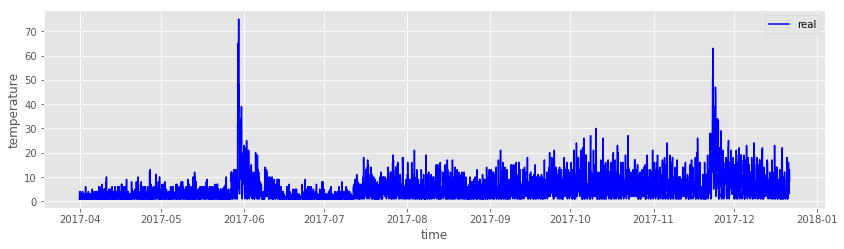

(6366, 1)


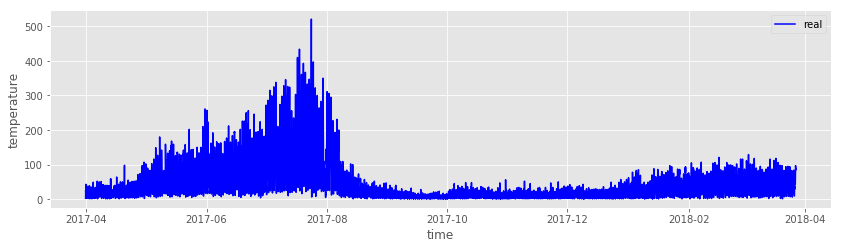

(8658, 1)


In [4]:
# trainデータの全期間plot
def show_graph(day, data, label, color="b"):
    pylab.figure(figsize=(14, 8))
    pylab.subplot(211)
    pylab.xlabel('time')
    pylab.ylabel('temperature')
    pylab.plot(day, data, color=color, label=label)
    pylab.legend(loc='upper right')
    pylab.show()
# bts
show_graph(b_hour,bcnt,'real')
print(bcnt.shape)

# mizugi
show_graph(m_hour,mcnt,'real')
print(mcnt.shape)

In [4]:
"""
特異変換スペクトル
'bts'の異常部位検出
"""

mss = MinMaxScaler()
train1_frame = pd.DataFrame(mss.fit_transform(bcnt))

def embed(lst, dim):
    emb = np.empty((0,dim), float)
    for i in range(lst.size - dim + 1):
        tmp = np.array(lst[i:i+dim])[::-1].reshape((1,-1)) 
        emb = np.append( emb, tmp, axis=0)
    return emb

train1=np.array(train1_frame[0],dtype='float64')

w = 168 # 部分時系列の要素数
m = 2 # 類似度算出に使用するSVDの次元数
k = int(w/2) # SVD算出に用いる部分時系列数
L = int(k/2) # # 類似度を比較する2つの部分時系列群間のラグ
Tt = train1.size
anomaly_score = np.zeros(Tt)

# 異常値のスコアを算出するメソッド
score_list=[]
for t in range(w+k, Tt-L+1+1):
    tstart = int(t-w-k+1)
    tend = t-1
    # t以前の部分時系列群
    X1 = embed(train1[tstart:tend], w).T[::-1, :] 
    # 異常度算出対象の部分時系列群(test matrix)
    X2 = embed(train1[(tstart+L):(tend+L)], w).T[::-1, :] 
    
    # X1にSVDを行い上位m次元を抜き出す
    U1, s1, V1 = np.linalg.svd(X1, full_matrices=True)
    U1 = U1[:,0:m]
    # X2にSVDを行い上位m次元を抜き出す
    U2, s2, V2 = np.linalg.svd(X2, full_matrices=True)
    U2 = U2[:,0:m]
    
    # U1とU2の最大特異値を取得
    U, s, V = np.linalg.svd(U1.T.dot(U2), full_matrices=True)
    sig1 = s[0]
    
    # 最大特異値の2ノルムを1から引くことで異常値を得る
    anomaly_score[t] = 1 - np.square(sig1)
    score_list.append(anomaly_score[t])

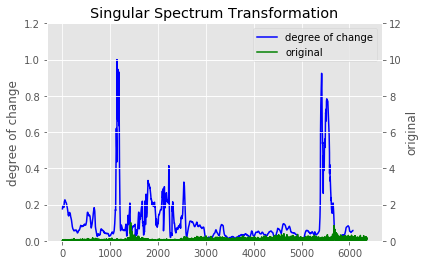

In [5]:
score_=np.reshape(score_list,(len(score_list),))

# 変化度をmax1にするデータ整形
mx = np.max(score_)
score_ = score_ / mx

# trainデータの異常部位plot
train_for_plot = np.array(train1_frame[0],dtype='float64')
fig = plt.figure()
ax1 = fig.add_subplot(111)
ax2 = ax1.twinx()

p1, = ax1.plot(score_, '-b')
ax1.set_ylabel('degree of change')
ax1.set_ylim(0, 1.2)
p2, = ax2.plot(train_for_plot, '-g')
ax2.set_ylabel('original')
ax2.set_ylim(0, 12.0)
plt.title("Singular Spectrum Transformation")
ax1.legend([p1, p2], ["degree of change", "original"])
plt.show()

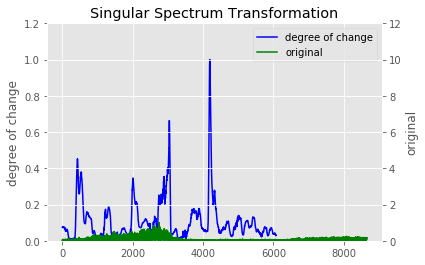

In [8]:
"""
'mizugi'の異常部位検出
"""

In [21]:
"""
学習データ
検証データ
テスト1,2 データ
"""

X_train = bcnt # (1104,)
X_valid = bcnt[3000:4500] # (504,)
X_test = bcnt[1000:2500]  # (408,)
X_test2 = mcnt[2000:3500]  # (504,)
X_train_day = b_hour
X_valid_day = b_hour[3000:4500]
X_test_day = b_hour[1000:2500]
X_test_day2 = m_hour[2000:3500]

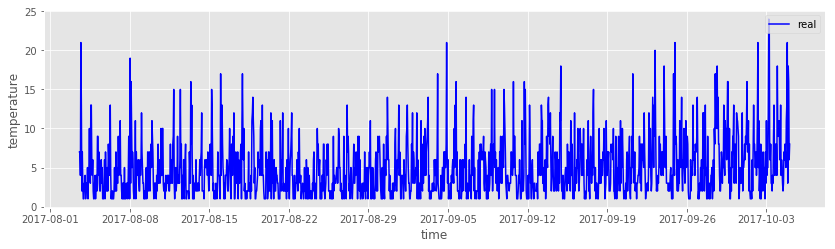

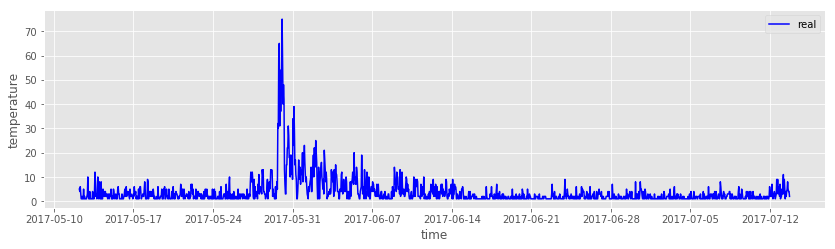

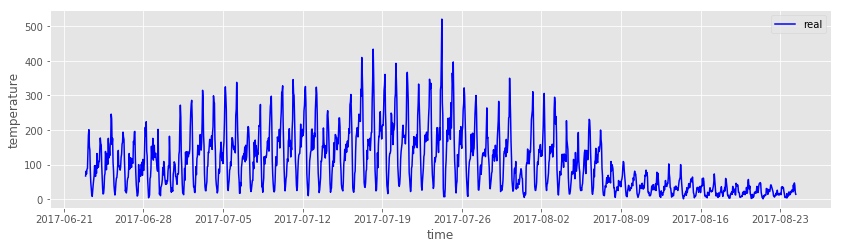

In [22]:
# valid, test, test1データのplot

# valid data
show_graph(X_valid_day,X_valid,'real')

# test data
show_graph(X_test_day, X_test,'real')

# test2 data
show_graph(X_test_day2, X_test2,'real')

In [23]:
"""
前処理/学習
get_data: データを前処理して深層学習で扱える形に変換する
transform_data: データを正規化してLSTMで学習が容易な形に変更する。
"""

def get_data(data, time_steps):
    docX, docY = [], []
    for i in range(len(data)-time_steps):
        docX.append(data[i:i+time_steps])
        docY.append(data[i+time_steps])
    alsX = np.array(docX)
    alsY = np.array(docY)
    return alsX, alsY

def transform_data(data, inverse_option, scaler):
    data_shape = data.shape
    if inverse_option is True:
        data = scaler.inverse_transform(data)
    else:
        data = scaler.fit_transform(data)
    data = data.reshape(data_shape)
    return data, scaler

def prepare_data(original_data, time_steps):
    copy_data = original_data.copy()
    scaler = MinMaxScaler(feature_range=(0, 1), copy=False)
    data, scaler = transform_data(data=copy_data, 
                              inverse_option=False, scaler=scaler)
    
    x,y = get_data(data, time_steps=time_steps)
    return x, y, scaler

time_steps = 12

x, y, scaler = prepare_data(X_train, time_steps)

input_dim=x.shape[-1]
timesteps=x.shape[1]
print(x.shape)
print(y.shape)

(6354, 12, 1)
(6354, 1)


In [24]:
"""
モデルの作成
自身の状態をリセットするかしないかを指定するstateful(周期的な波形はTrueの方が若干良い）
"""
model = Sequential()
model.add(LSTM(300, input_shape=(timesteps, input_dim),
         stateful=False,return_sequences=True))
model.add(Flatten())
model.add(Dense(1, kernel_initializer='lecun_uniform'))
model.add(Activation("linear"))
#model.load_weights('/Users/tatsuyahagiwara/d/cnt_label/week_dir/model.ep200.h5')
model.compile(loss="mean_squared_error", optimizer="adam",)

In [25]:
history = History()
callback = []
#callbacks.append(ModelCheckpoint(filepath="model.best.h5", save_best_only=True))
callback.append(history)
callback.append(ModelCheckpoint(filepath="/Users/tatsuyahagiwara/d/cnt_label/week_dir/model.ep{epoch:02d}.h5"))


In [ ]:
# 訓練
history = model.fit(x, y, epochs=200, batch_size=500, callbacks=callback)

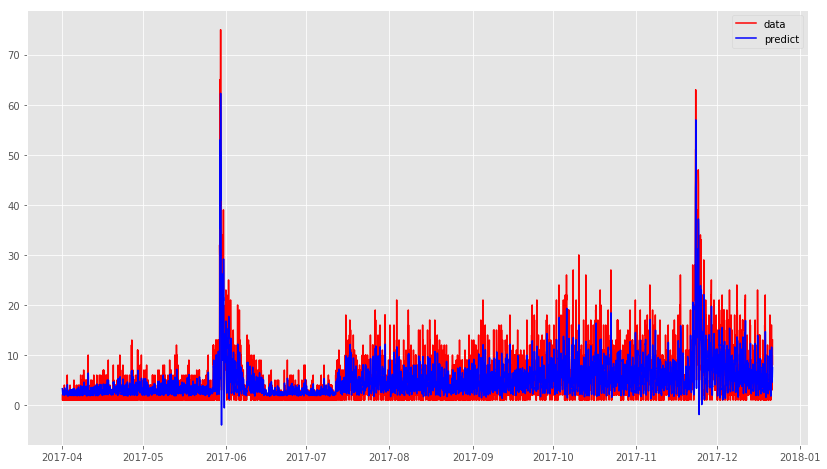

In [27]:
"""
データを正規化後の値に戻して予測結果が適切か確認
"""

# 学習データとその予測データのplot
def predict_model_show_graph(day, x, y_, scaler, model,time_steps=3):
    preds = model.predict(x)
    x = np.reshape(y_, (len(y_),))
    x_scale, scaler = transform_data(data=y_, inverse_option=True, scaler=scaler)
    predict_scale, scaler = transform_data(data=preds, inverse_option=True, scaler=scaler)
    
    plt.figure(figsize=(14, 8))
    plt.plot(day, x_scale[:,0], color='r', label='data')
    plt.plot(day, predict_scale[:,0], color='b', label='predict')
    plt.legend()
    plt.show()
    return predict_scale, x_scale
window = time_steps
x_predict, y_ ,scaler = prepare_data(X_train, time_steps)
predict_train, x_scale_train = predict_model_show_graph(X_train_day[window:], x_predict, y_, scaler, model)

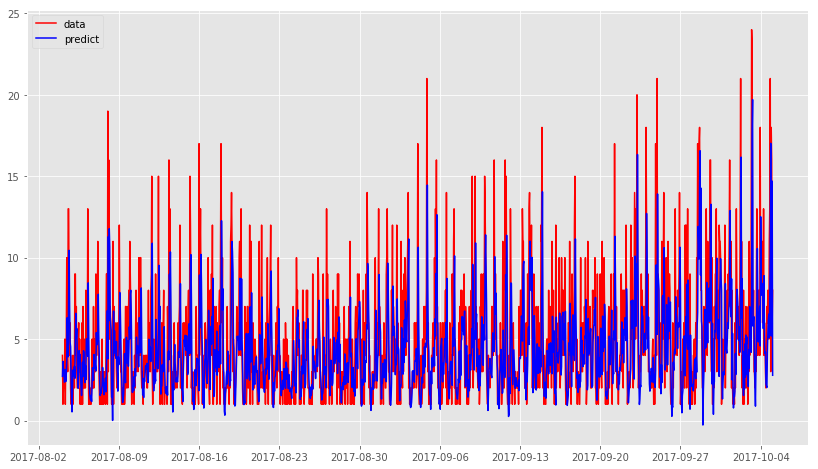

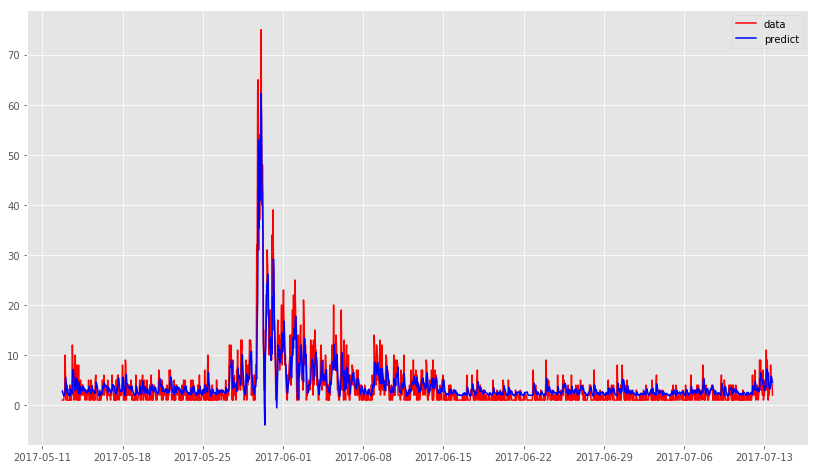

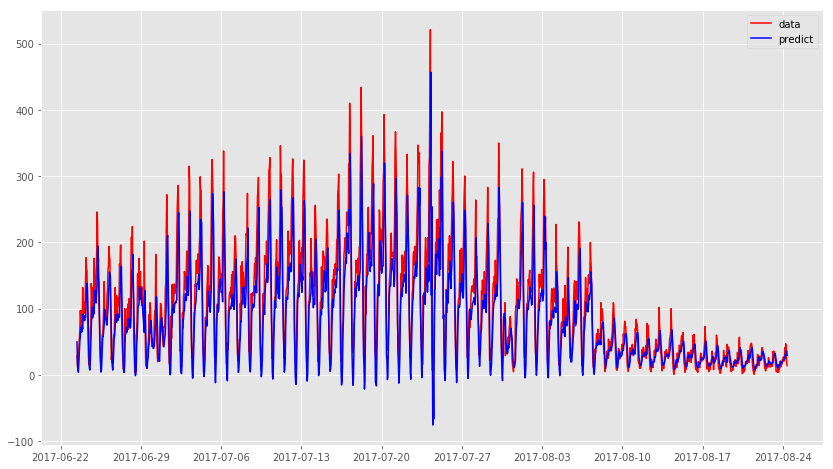

In [28]:
# 検証データとその予測データのplot
x_valid_pred,y_, scaler_valid = prepare_data(X_valid, time_steps)
predict_valid, x_scale_valid = predict_model_show_graph(X_valid_day[window:], x_valid_pred, y_, scaler_valid, model)

# テストデータとその予測データのplot
x_test_pred,y_, scaler_valid = prepare_data(X_test, time_steps)
predict_test, x_scale_test = predict_model_show_graph(X_test_day[window:], x_test_pred, y_, scaler_valid, model)

# テストデータ2とその予測データのplot
x_test_pred2,y2_, scaler_valid2 = prepare_data(X_test2, time_steps)
predict_test2, x_scale_test2 = predict_model_show_graph(X_test_day2[window:], x_test_pred2, y2_, scaler_valid2, model)

In [29]:
"""
閾値設定について

trainデータの実際の数値が2桁のデータ（異常あり）を選択
同じ値の範囲（2桁）で異常がないデータをvalidデータに選択し、そのMSEの最大値を閾値に設定

test1データ、test2データは共に実際の値が3桁の値なので、通常の閾値（threshold）
だと低すぎる。なのでtest1,2の元データの「平均値/2」（整数or小数）の値を閾値にかけてデータごとに
最適な新しい閾値(high_threshold)を設定する。
ex1:
N=int(np.mean(x_scale_test)/2)
high_threshold = threshold*N 

ex2:
N=float(np.mean(x_scale_test)/2)
high_threshold = threshold*N 

"""
# 閾値計算

def calculate_mse(value, predict_value, variance=1.0):
    value = value[:, 0]
    predict_value = predict_value[:, 0]
    mse_value = [(v - p_v)**2 for v, p_v in zip(value, predict_value)]
    return np.array(mse_value)


mse_value_valid = calculate_mse(x_scale_valid, predict_valid)
threshold = np.max(mse_value_valid)
print('threshold:{}'.format(threshold)) # 閾値
print('train data mean:{}'.format(np.mean(x_scale_train)))  # 閾値

threshold:249.16269761799867
train data mean:4.969310670443815


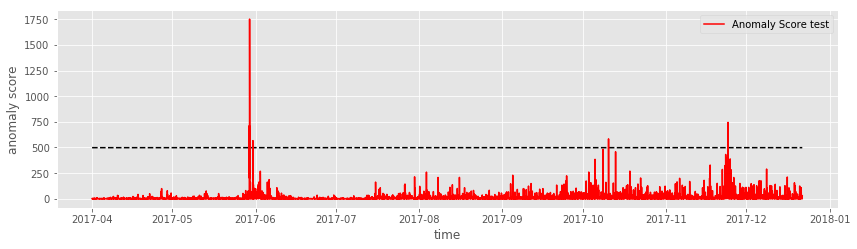

threshold:249.16269761799867
high_threshold:498.32539523599735


In [30]:
"""
Train Data Case
訓練データの異常部分を検知するかを確認
"""

def show_graph_threshold(day, data, threshold, label, color="b", fix_threshold=True):
    pylab.figure(figsize=(14, 8))
    pylab.subplot(211)
    pylab.xlabel('time')
    pylab.ylabel('anomaly score')
    if fix_threshold is True:
        pylab.plot(day, np.repeat(threshold, day.shape[0]), 'k-', color = "k", ls = "dashed")
    else:
        pylab.plot(day, threshold, 'k-', color = "k", ls = "dashed")
    pylab.plot(day, data, "r", label='Anomaly Score test')
    pylab.legend(loc='upper right')
    pylab.show()

mse_value_normal = calculate_mse(x_scale_train, predict_train)
N=int(np.mean(x_scale_train)/2)
high_threshold = threshold*N 

show_graph_threshold(X_train_day[window:], mse_value_normal, high_threshold, 'Anomaly Score test', "r")

print('threshold:{}'.format(threshold))
print('high_threshold:{}'.format(high_threshold))

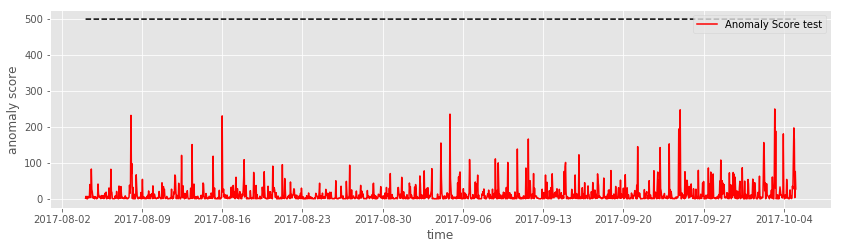

threshold:249.16269761799867
high_threshold:498.32539523599735


In [31]:
"""
Normal Data Case
検証データ（正常データ）を異常を検知しないかを確認
"""
mse_valid = calculate_mse(x_scale_valid, predict_valid)
N=int(np.mean(x_scale_valid)/2)
high_threshold = threshold*N 

show_graph_threshold(X_valid_day[window:], mse_valid, high_threshold, 'Anomaly Score test', "r")

print('threshold:{}'.format(threshold))
print('high_threshold:{}'.format(high_threshold))

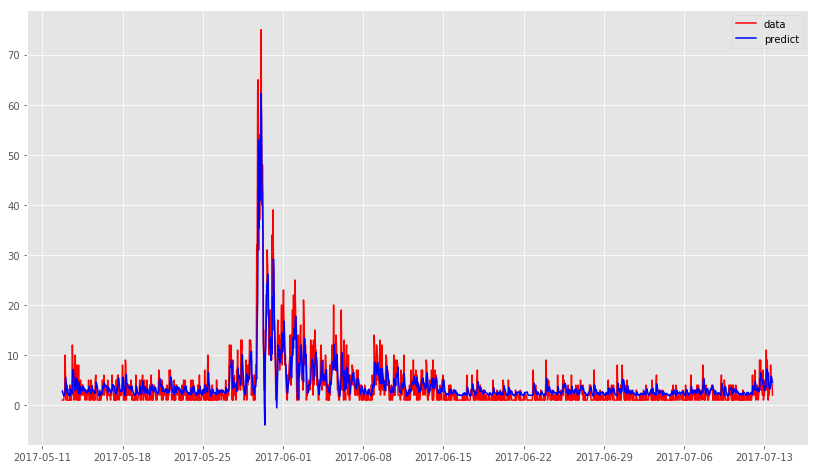

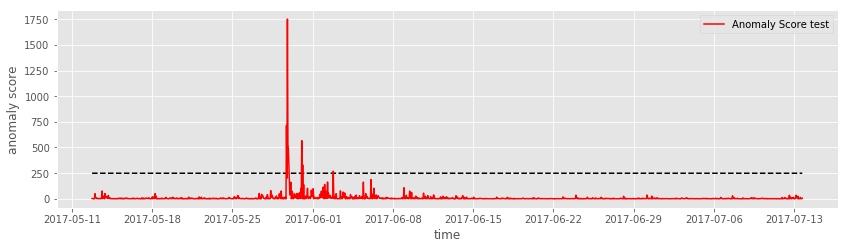

threshold:249.16269761799867
high_threshold:249.16269761799867
Test1 anomaly hour: 2017-05-29 17:00:00
Test1 anomaly hour: 2017-05-29 19:00:00
Test1 anomaly hour: 2017-05-29 20:00:00
Test1 anomaly hour: 2017-05-29 21:00:00
Test1 anomaly hour: 2017-05-29 22:00:00
Test1 anomaly hour: 2017-05-31 01:00:00
Test1 anomaly hour: 2017-05-31 03:00:00
Test1 anomaly hour: 2017-06-02 19:00:00


In [32]:
"""
Anomaly Data Case
異常データ（テスト1,2データ）を異常として検知するかを確認
"""

# テストデータ1とその予測データのplot
x_test_pred,y_, scaler_valid = prepare_data(X_test, time_steps)
predict_test, x_scale_test = predict_model_show_graph(X_test_day[window:], x_test_pred, y_, scaler_valid, model)

# 閾値設定と異常値plot
mse_value_test = calculate_mse(x_scale_test, predict_test)
N=int(np.mean(x_scale_test)/2)
high_threshold = threshold*N 

show_graph_threshold(X_test_day[window:], mse_value_test, high_threshold, 'Anomaly Score test', "r")

print('threshold:{}'.format(threshold))
print('high_threshold:{}'.format(high_threshold))

# 急上昇ワードの時間を表示
for mse, hour in zip(mse_value_test, X_test_day[window:]):
    if mse >= threshold:
        print("Test1 anomaly hour:", hour)

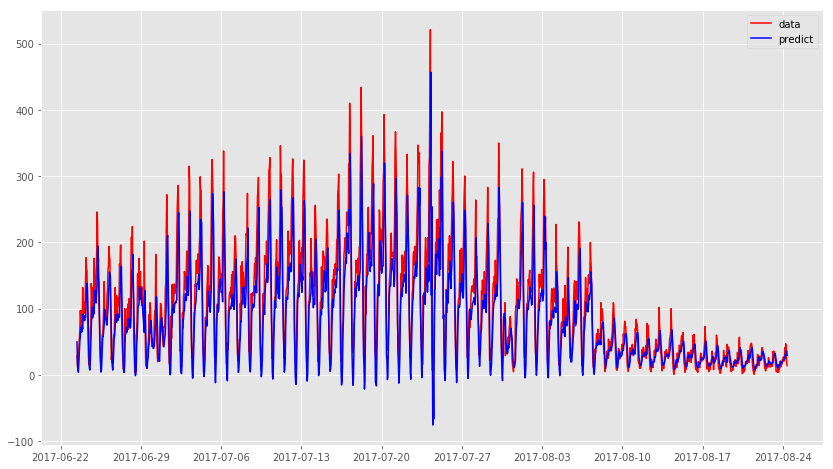

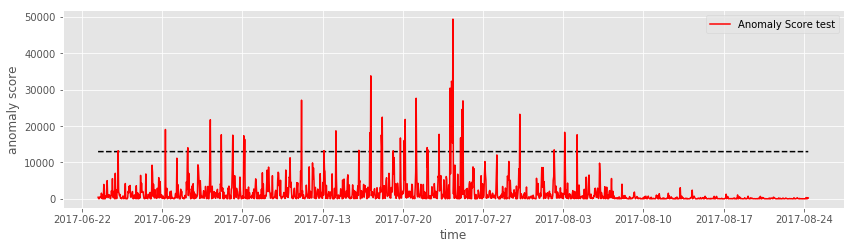

threshold:249.16269761799867
high_threshold:12956.460276135931
Test2 anomaly hour: 2017-06-25 04:00:00
Test2 anomaly hour: 2017-06-29 07:00:00
Test2 anomaly hour: 2017-07-01 06:00:00
Test2 anomaly hour: 2017-07-03 05:00:00
Test2 anomaly hour: 2017-07-04 04:00:00
Test2 anomaly hour: 2017-07-05 04:00:00
Test2 anomaly hour: 2017-07-06 03:00:00
Test2 anomaly hour: 2017-07-06 05:00:00
Test2 anomaly hour: 2017-07-11 04:00:00
Test2 anomaly hour: 2017-07-13 03:00:00
Test2 anomaly hour: 2017-07-14 04:00:00
Test2 anomaly hour: 2017-07-16 04:00:00
Test2 anomaly hour: 2017-07-17 03:00:00
Test2 anomaly hour: 2017-07-17 05:00:00
Test2 anomaly hour: 2017-07-18 03:00:00
Test2 anomaly hour: 2017-07-18 04:00:00
Test2 anomaly hour: 2017-07-18 05:00:00
Test2 anomaly hour: 2017-07-19 04:00:00
Test2 anomaly hour: 2017-07-19 19:00:00
Test2 anomaly hour: 2017-07-20 03:00:00
Test2 anomaly hour: 2017-07-20 05:00:00
Test2 anomaly hour: 2017-07-21 04:00:00
Test2 anomaly hour: 2017-07-22 03:00:00
Test2 anomaly hou

In [33]:
# テストデータ2とその予測データのplot
x_test_pred2,y2_, scaler_valid2 = prepare_data(X_test2, time_steps)
predict_test2, x_scale_test2 = predict_model_show_graph(X_test_day2[window:], x_test_pred2, y2_, scaler_valid2, model)


# 閾値設定と異常値plot
mse_value_test2 = calculate_mse(x_scale_test2, predict_test2)
N=int(np.mean(x_scale_test2)/2)
high_threshold = threshold*N


show_graph_threshold(X_test_day2[window:], mse_value_test2, high_threshold, 'Anomaly Score test', "r")
print('threshold:{}'.format(threshold))
print('high_threshold:{}'.format(high_threshold))


# 急上昇ワードの時間を表示
for mse, hour in zip(mse_value_test2, X_test_day2[window:]):
    if mse >= high_threshold:
        print("Test2 anomaly hour:", hour)